<a href="https://colab.research.google.com/github/cardstdani/StorageColabNotebooks/blob/main/Algoritmos_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**



In [ ]:
!pip install googletrans==3.1.0a0
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install tensorflow
!pip install opencv-python
!pip install mediapipe
!pip install imutils
!pip install keras
!pip install SpeechRecognition
!pip3 install --upgrade Pillow

     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 1.3 MB 8.8 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 65 kB 3.6 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=aec6bf8faf50b19cb46af18e4b088ee3a0cc21dc09ac973bfbd754029668a2b8
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of add

     |████████████████████████████████| 462 kB 5.3 MB/s 
     |████████████████████████████████| 32.7 MB 1.5 MB/s 
     |████████████████████████████████| 32.8 MB 73.1 MB/s 


In [ ]:
from google.colab.patches import cv2_imshow
from googletrans import Translator
import tensorflow as tf
import numpy as np
import IPython.display as display
import PIL.Image
import matplotlib.pyplot as plt
import cv2
import random
import mediapipe as mp
import math
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import speech_recognition as sr
import time

**Deep Dream**



In [ ]:
def deprocess(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)


original_img = np.array(PIL.Image.open('/content/drive/MyDrive/IA_Test_Images/NoMask.png'))
base_model = tf.keras.applications.MobileNetV3Small(include_top=False, weights='imagenet')
layer_names = [layer.name for layer in base_model.layers]
print(layer_names)
# Maximize the activations of these layers
names = random.sample(layer_names, 6)
layers = [base_model.get_layer(name).output for name in names]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)


class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
                tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.int32),
                tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)

            gradients = tape.gradient(loss, img)
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img


deepdream = DeepDream(dream_model)


def run_deep_dream_simple(img, steps=100, step_size=0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        print("Step {}, loss {}".format(step, loss))

    result = deprocess(img)
    display.clear_output(wait=True)

    return result

def random_roll(img, maxroll):
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    img_rolled = tf.roll(img, shift=shift, axis=[0, 1])
    return shift, img_rolled


class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
                tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.int32),)
    )
    def __call__(self, img, tile_size=512):
        shift, img_rolled = random_roll(img, tile_size)
        gradients = tf.zeros_like(img_rolled)
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
                with tf.GradientTape() as tape:
                    tape.watch(img_rolled)

                    # Extract a tile out of the image.
                    img_tile = img_rolled[x:x + tile_size, y:y + tile_size]
                    loss = calc_loss(img_tile, self.model)

                gradients = gradients + tape.gradient(loss, img_rolled)

        gradients = tf.roll(gradients, shift=-shift, axis=[0, 1])
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        return gradients


get_tiled_gradients = TiledGradients(dream_model)

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]


def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01,
                                octaves=range(-2, 3), octave_scale=1.3):
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32) * (octave_scale ** octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)

            if step % 2 == 0:
                display.clear_output(wait=True)
                print("Octave {}, Step {}".format(octave, step))

    result = deprocess(img)
    return result


img = run_deep_dream_with_octaves(img=original_img, steps_per_octave=50, step_size=0.01,octaves=range(-2, 3), octave_scale=1.6)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img / 255.0, dtype=tf.uint8)
cv2_imshow(cv2.cvtColor(img.numpy(), cv2.COLOR_RGB2BGR))

#dream_img = run_deep_dream_simple(img=original_img, steps=30, step_size=0.01)
#cv2.imshow("image", cv2.cvtColor(dream_img.numpy(), cv2.COLOR_BGR2RGB))
print(names)

**Convolutions**



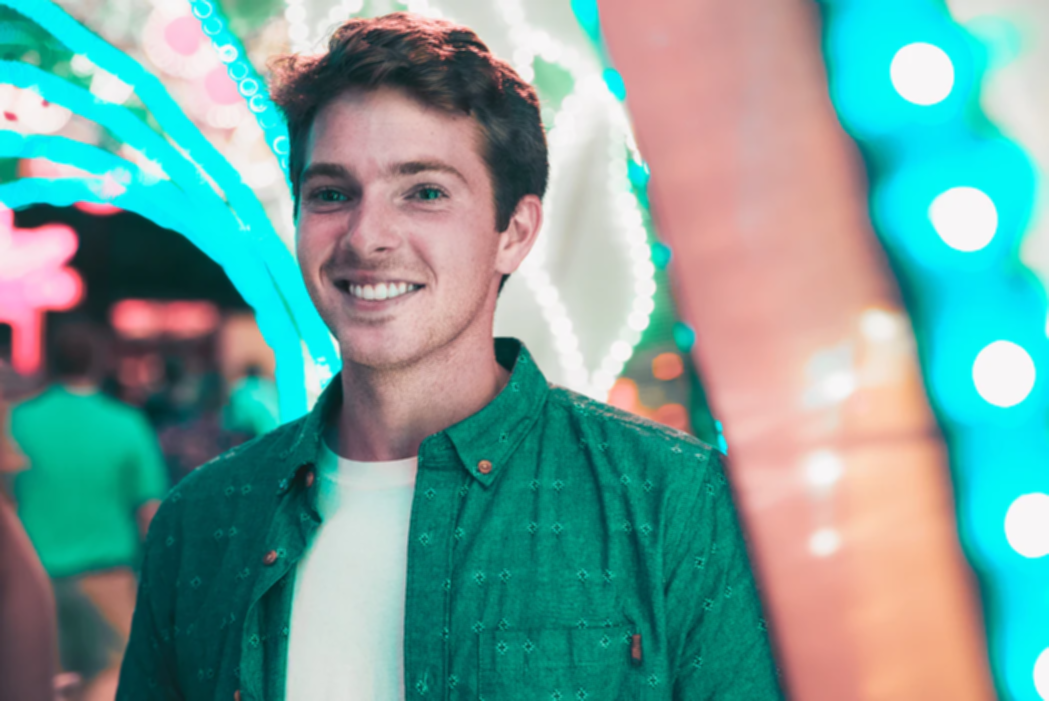

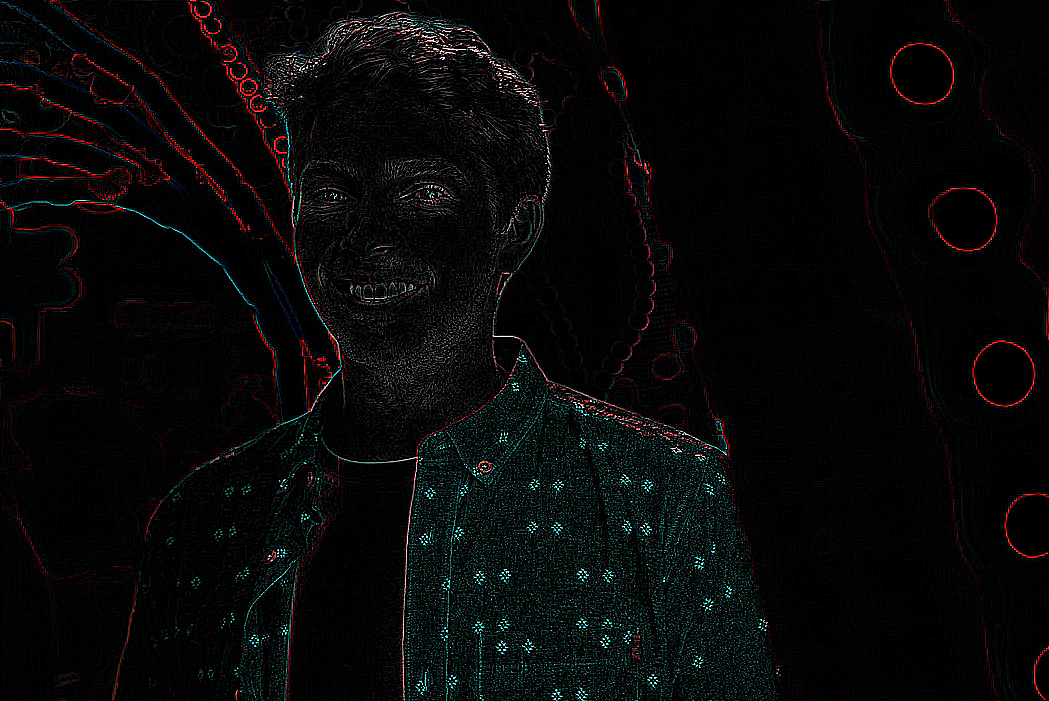

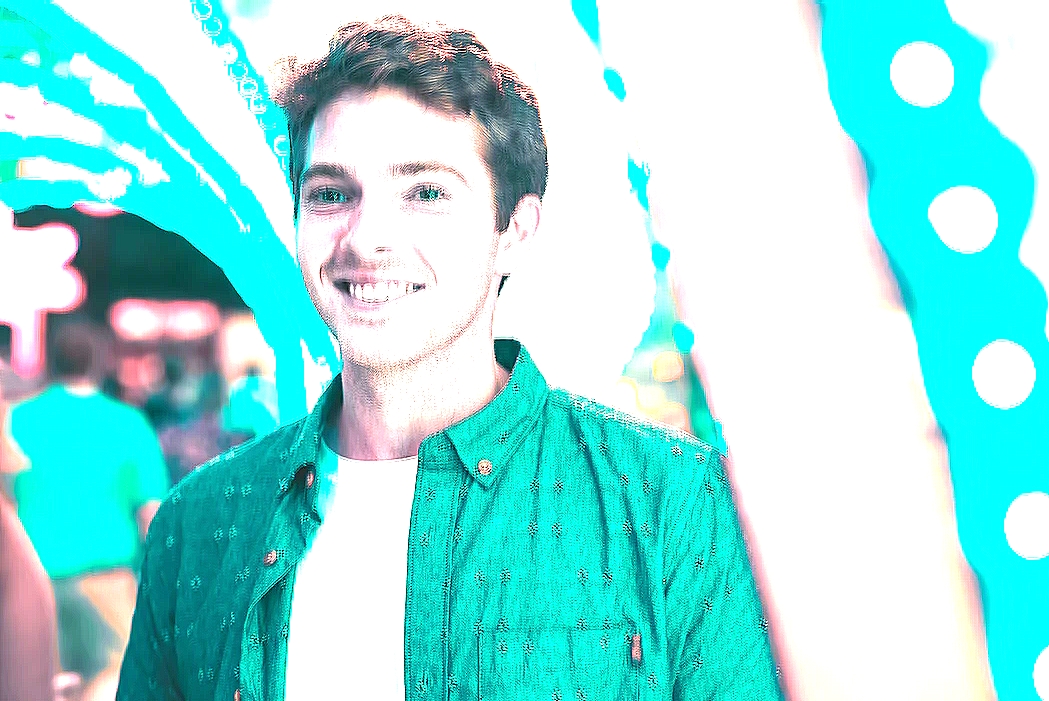

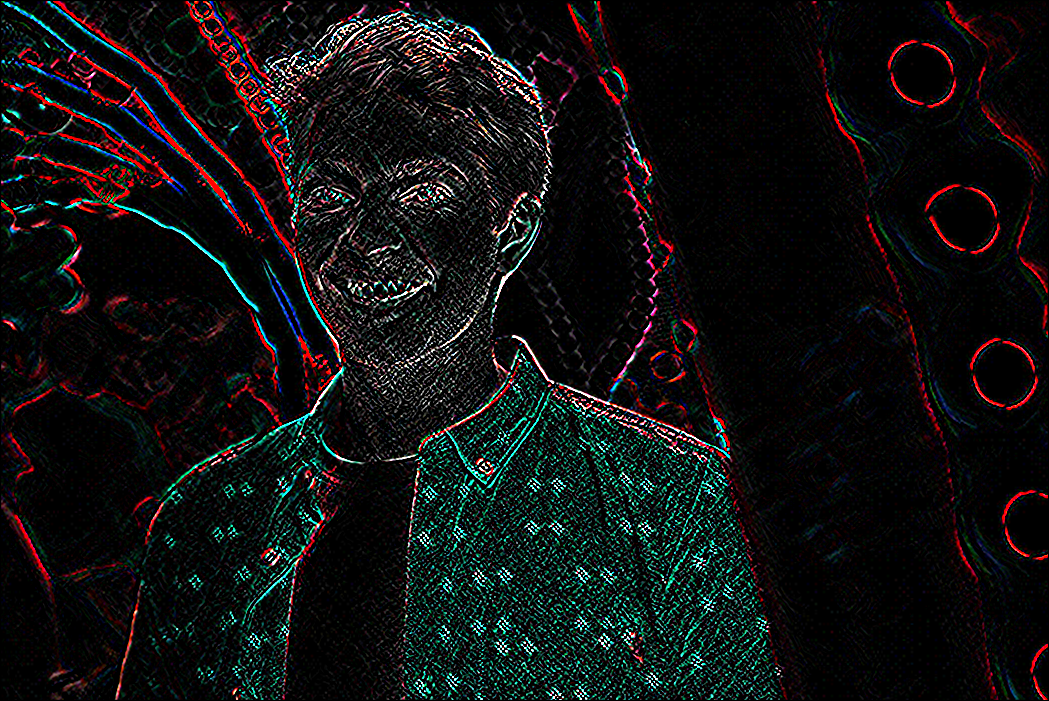

In [ ]:
blurValue = 9
kernelBlur = np.array([[1 / blurValue, 1 / blurValue, 1 / blurValue],
        [1 / blurValue, 1 / blurValue, 1 / blurValue],
        [1 / blurValue, 1 / blurValue, 1 / blurValue]] )

kernelEdge = np.array([[-1, -1, -1],
        [-1, 8, -1],
        [-1, -1, -1]]*1)

kernelEnhance = np.array([[0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]]*2)

frame = cv2.imread("/content/drive/MyDrive/IA_Test_Images/NoMask.png")
#frame = cv2.flip(frame, 1)

cv2_imshow(cv2.filter2D(frame, -1, kernelBlur))
cv2_imshow(cv2.filter2D(frame, -1, kernelEdge))
cv2_imshow(cv2.filter2D(frame, -1, kernelEnhance))
cv2_imshow(cv2.Sobel(frame, -1,1,1,ksize=5))

**Road detection**



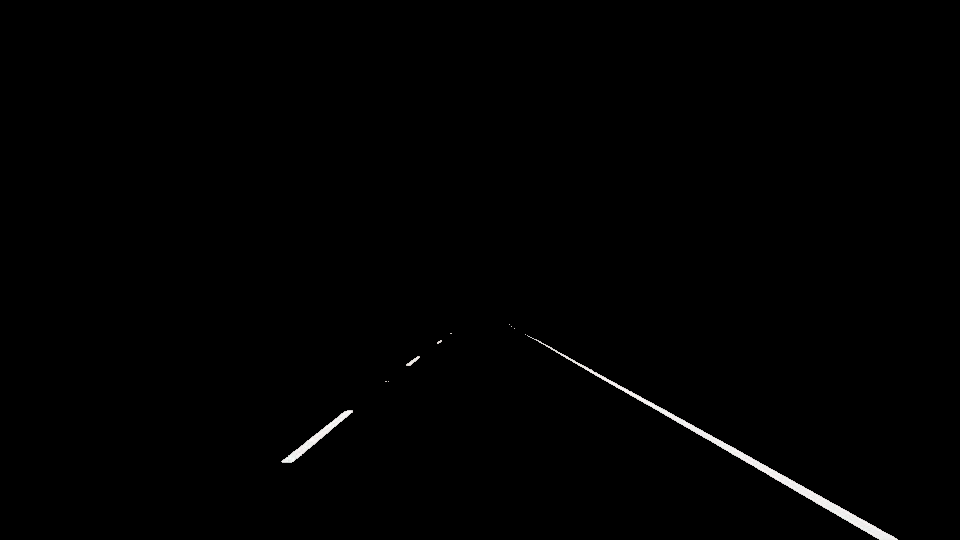

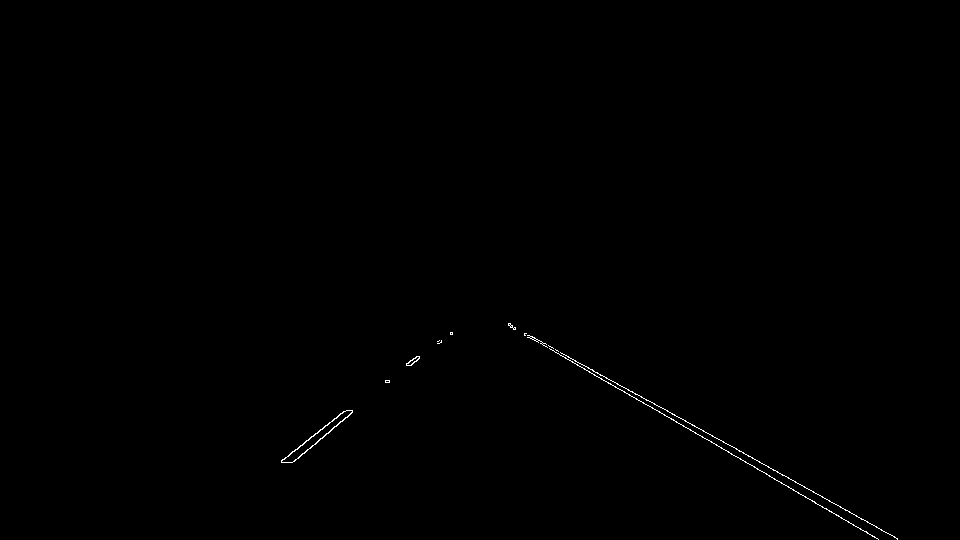

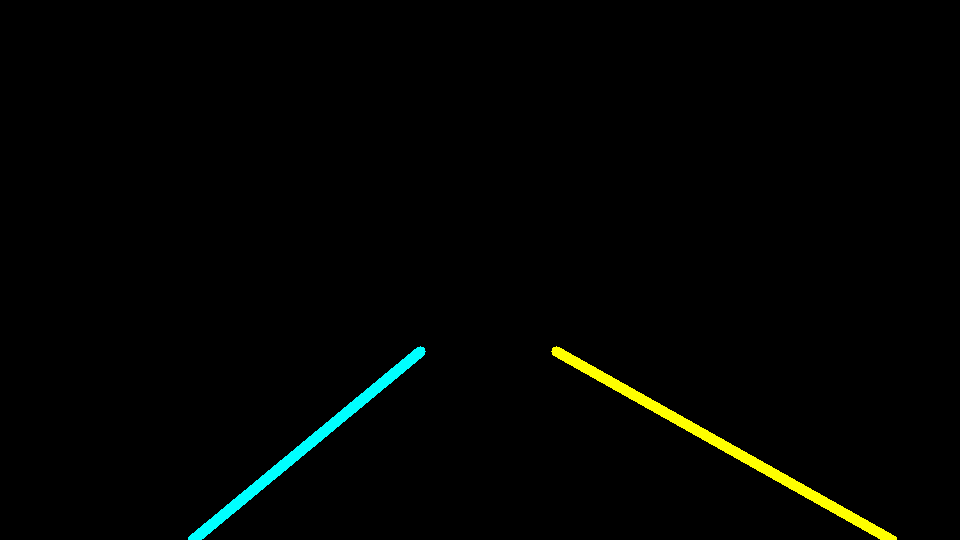

In [ ]:
img = cv2.imread("/content/drive/MyDrive/RoadImage.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
def color_filter(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.array([0,190,0])
    upper = np.array([255,255,255])
    yellower = np.array([10,0,90])
    yelupper = np.array([50,255,255])
    yellowmask = cv2.inRange(hls, yellower, yelupper)
    whitemask = cv2.inRange(hls, lower, upper)
    mask = cv2.bitwise_or(yellowmask, whitemask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

def roi(img):
    x = int(img.shape[1])
    y = int(img.shape[0])
    shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

rightSlope, leftSlope, rightIntercept, leftIntercept = [], [], [], []

def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y1 - y2) / (x1 - x2)
            if slope > 0.3:
                if x1 > 500:
                    yintercept = y2 - (slope * x2)
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else:
                    None
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope * x2)
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])
    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])
    try:
        left_line_x1 = int((0.65 * img.shape[0] - leftavgIntercept) / leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept) / leftavgSlope)
        right_line_x1 = int((0.65 * img.shape[0] - rightavgIntercept) / rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept) / rightavgSlope)
        pts = np.array([[left_line_x1, int(0.65 * img.shape[0])], [left_line_x2, int(img.shape[0])],
                        [right_line_x2, int(img.shape[0])], [right_line_x1, int(0.65 * img.shape[0])]], np.int32)
        pts = pts.reshape((-1, 1, 2))
        #cv2.fillPoly(img, [pts], (250, 250, 250))
        cv2.line(img, (left_line_x1, int(0.65 * img.shape[0])), (left_line_x2, int(img.shape[0])), [255, 255, 0], 10)
        cv2.line(img, (right_line_x1, int(0.65 * img.shape[0])), (right_line_x2, int(img.shape[0])), [0, 255, 255], 10)
    except ValueError:
        pass


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def linedetect(img):
    return hough_lines(img, 1, np.pi / 180, 10, 20, 100)


cv2_imshow(np.array(roi(color_filter(img))))
cv2_imshow(np.array(cv2.Canny(cv2.cvtColor(roi(color_filter(img)), cv2.COLOR_RGB2GRAY), 50, 120)))
cv2_imshow(np.array(linedetect(cv2.Canny(cv2.cvtColor(roi(color_filter(img)), cv2.COLOR_RGB2GRAY), 50, 120))))

**Google translate**



In [ ]:
translator = Translator(service_urls=['translate.googleapis.com'])
print(translator.translate("Buenos días", dest='en'))

Translated(src=es, dest=en, text=Good Morning, pronunciation=Good Morning, extra_data="{'translat...")


**Text detector**



In [ ]:
try:
    from PIL import Image
except ImportError:
    import Image

import pytesseract
for i in range(2):
  print("\n")
print(pytesseract.image_to_string(Image.open('/content/drive/MyDrive/Untitled1.png')))





Texto de ejemplo



**Hand detector**



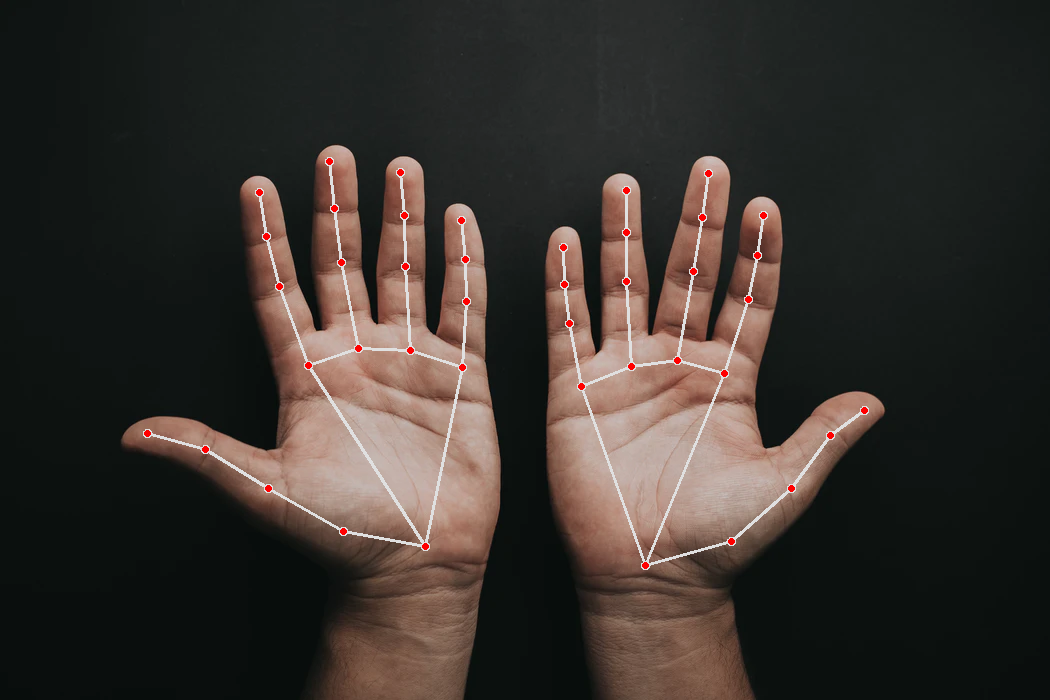

In [ ]:
mpHands = mp.solutions.hands
hands = mpHands.Hands()
mpDraw = mp.solutions.drawing_utils

img = cv2.imread("/content/drive/MyDrive/IA_Test_Images/HandsImage.png")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = hands.process(imgRGB)

if results.multi_hand_landmarks:
    for handLms in results.multi_hand_landmarks: #Por cada mano
        for id, lm in enumerate(handLms.landmark): #Por cada articulación detectado
            h, w, c = img.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            cv2.circle(img, (cx, cy), 4, (255, 0, 255), cv2.FILLED)

        mpDraw.draw_landmarks(img, handLms, mpHands.HAND_CONNECTIONS)

cv2_imshow(img)

In [ ]:
"""Webcam Version"""
import cv2
import mediapipe as mp

cap = cv2.VideoCapture(0)

mpHands = mp.solutions.hands
hands = mpHands.Hands()
mpDraw = mp.solutions.drawing_utils
mpDrawingStyles = mp.solutions.drawing_styles

with mpHands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, img = cap.read()
        results = hands.process(img)

        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:  # Por cada mano
                for id, lm in enumerate(handLms.landmark):  # Por cada articulación detectado
                    h, w, c = img.shape
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    cv2.circle(img, (cx, cy), 4, (255, 0, 255), cv2.FILLED)

                mpDraw.draw_landmarks(img, handLms, mpHands.HAND_CONNECTIONS, mpDrawingStyles.get_default_hand_landmarks_style(), mpDrawingStyles.get_default_hand_connections_style())
        cv2.imshow("Frame", img)
        if cv2.waitKey(5) & 0xFF == 112:
            break
cap.release()

**Fingers up detector**



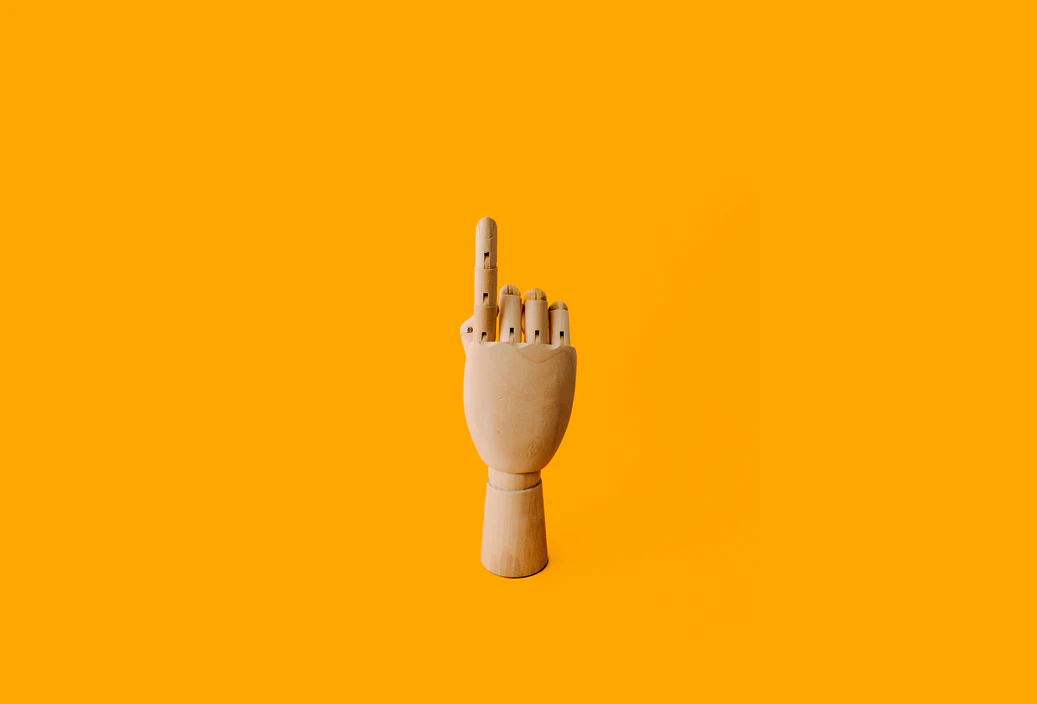

In [ ]:
mpHands = mp.solutions.hands
hands = mpHands.Hands()
mpDraw = mp.solutions.drawing_utils

x, y = 0, 0
color = (0, 255, 255)
tipIds = [4, 8, 12, 16, 20]

#Procesar la imagen
img = cv2.imread("/content/drive/MyDrive/IA_Test_Images/FingerUp.png")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = hands.process(imgRGB)

if results.multi_hand_landmarks:
    for handLms in results.multi_hand_landmarks:  # Por cada mano
        fingerList = []
        for id, lm in enumerate(handLms.landmark):  # Por cada dedo detectado
                h, w, c = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                fingerList.append([cx, cy])

        fingersUp = 0

        if fingerList[tipIds[0]][1] > fingerList[tipIds[0] - 1][1]:
                fingersUp += 1
        #Detectar los dedos levantados
        for id in range(1, 5):
            if fingerList[tipIds[id]][1] < fingerList[tipIds[id] - 2][1]:
                fingersUp += 1

        x2, y2 = fingerList[8][0], fingerList[8][1]
        x, y = fingerList[4][0], fingerList[4][1]
        cv2.circle(img, (x, y), 8, color, cv2.FILLED)
        cv2.putText(img, str(fingersUp), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255))

        mpDraw.draw_landmarks(img, handLms, mpHands.HAND_CONNECTIONS)
        print(fingersUp)

cv2_imshow(img)

**Pose detector**



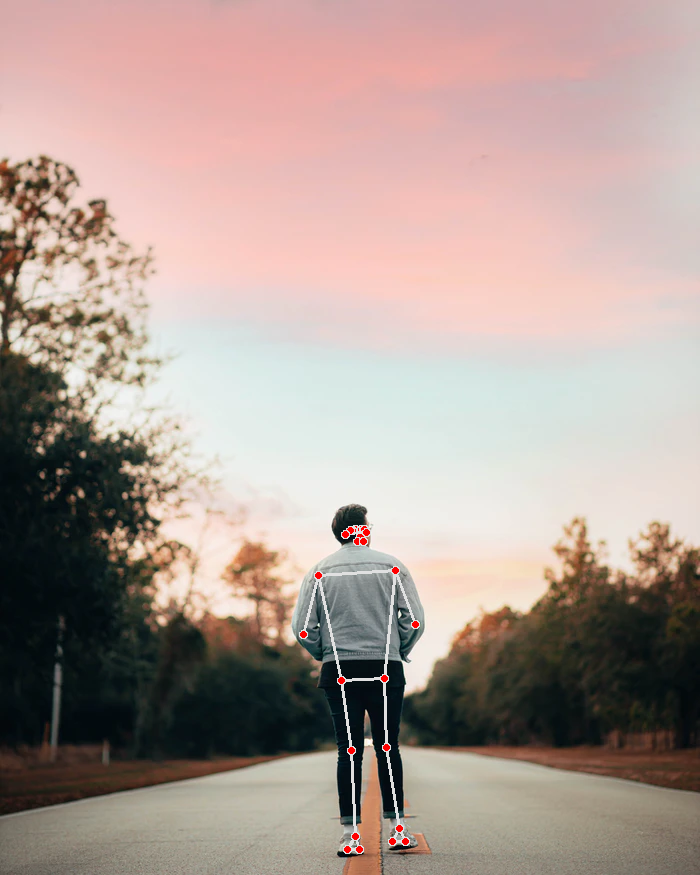

In [ ]:
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    #Procesar la imagen
    image = cv2.imread("/content/drive/MyDrive/IA_Test_Images/PersonWalking.png")

    #image = cv2.flip(image, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = holistic.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #Mostrar los resultados
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    cv2_imshow(image)


In [ ]:
"""WebCam Version"""
import cv2
import mediapipe as mp

cap = cv2.VideoCapture(0)

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
mpDrawingStyles = mp.solutions.drawing_styles

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        success, img = cap.read()

        results = holistic.process(img)

        # Mostrar los resultados
        mp_drawing.draw_landmarks(img, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(img, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, mpDrawingStyles.get_default_pose_landmarks_style())
        cv2.imshow("Frame", img)
        if cv2.waitKey(5) & 0xFF == 112:
            break
cap.release()

**Mask detector**



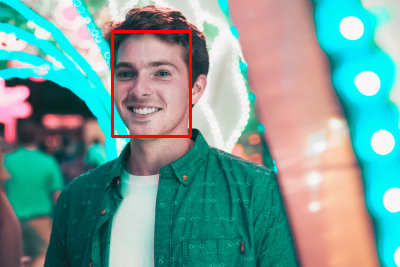

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os


def detect_and_predict_mask(frame, faceNet, maskNet):
    #Cargar la red neuronal y detectar caras
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))

    #Cargar datos de entrada y propagar la red hacia adelante
    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    preds = []

    #Considerar las detecciones según su fiabilidad
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            #Si la fiabilidad es suficiente, calcular los rectangulos que contienen las detecciones
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0: #Si se detectan caras, predecir si contienen mascarilla
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)
    #Devolver los valores de los rectangulos que contienen todas las caras detectadas en la imagen y sus predicciones
    return (locs, preds)


prototxtPath = "/content/drive/MyDrive/IA_Test_Images/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/IA_Test_Images/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
maskNet = load_model("/content/drive/MyDrive/IA_Test_Images/mask_detector.model")

frame = cv2.imread("/content/drive/MyDrive/IA_Test_Images/NoMask.png")
frame = imutils.resize(frame, width=400)

(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

# por cada predicción
for (box, pred) in zip(locs, preds):
    # Extraer los datos de las predicciones
    (startX, startY, endX, endY) = box
    (mask, withoutMask) = pred

    label = ""#"1" if mask > withoutMask else "0"
    color = (0, 255, 0) if label == "1" else (0, 0, 255)

    #Mostrar resultados
    label = "{} {:.2f}%".format(label, max(mask, withoutMask) * 100)
    #cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    cv2_imshow(frame)


**Face detector**



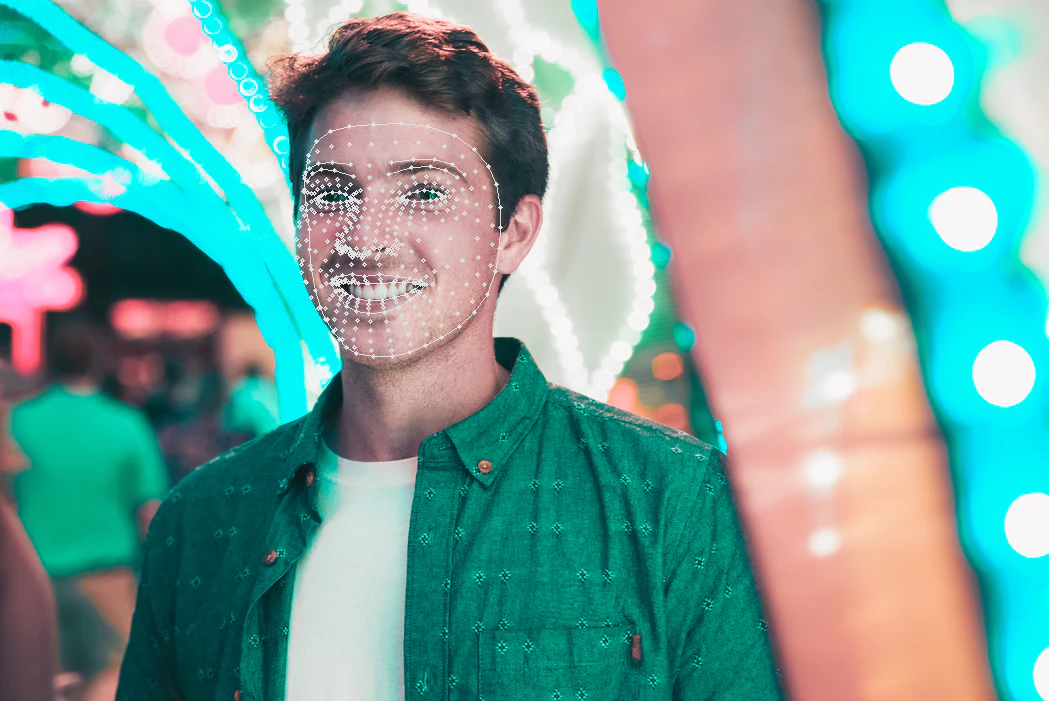

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        image = cv2.imread("/content/drive/MyDrive/IA_Test_Images/NoMask.png")

        #image = cv2.flip(image, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = face_mesh.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_face_landmarks: #Si se detectan resultados
            for face_landmarks in results.multi_face_landmarks: #Iterar y mostrar los resultados
                mp_drawing.draw_landmarks(image=image, landmark_list=face_landmarks,connections=mp_face_mesh.FACEMESH_CONTOURS,landmark_drawing_spec=drawing_spec,connection_drawing_spec=drawing_spec)
        cv2_imshow(image)

In [ ]:
"""WebCam Version"""
import cv2
import mediapipe as mp

cap = cv2.VideoCapture(0)

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
mpDrawingStyles = mp.solutions.drawing_styles

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        success, img = cap.read()

        results = face_mesh.process(img)
        if results.multi_face_landmarks:  # Si se detectan resultados
            for face_landmarks in results.multi_face_landmarks:  # Iterar y mostrar los resultados
                mp_drawing.draw_landmarks(img, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, drawing_spec, mpDrawingStyles.get_default_face_mesh_contours_style())
        cv2.imshow("Frame", img)
        if cv2.waitKey(5) & 0xFF == 112:
            break
cap.release()

**Mnist number generator**



In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow as tf

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
generator = make_generator_model()
noise = tf.random.normal([1, 100])

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

train(train_dataset, EPOCHS)

11501568/11490434 [==============================] - 0s 0us/step


KeyboardInterrupt: ignored

**Recursion**



In [ ]:
def sum(n, m):
  if n==1 or m==1:
    return 1
  else:
    return (n-1)*(m-1) + sum(n-1, m-1)
print(sum(1, 2))

**Operadores**



In [ ]:
#Operadores de asignación
a = 1
print(a)

a *= 2
print(a)

a /= 2
print(a)

a = int(a)
a += 2
print(a)

a -= 2
print(a)

a %= 2
print(a)

a <<= 2
print(a)

a >>= 2
print(a)

a &= 2
print(a)

a ^= 2
print(a)

a |= 2
print(a)

#Operadores lógicos
print(True and True)

print(True or False)

print(not False)

#Operadores aritmétricos
print(1+1)

print(1-1)

print(1*1)

print(10**0)

print(1/1)

print(1%1)

#Operadores relacionales
print(1==1)

print(1!=1)

print(2>1)

print(1<2)

print(1>=1)

print(1<=2)

print(not (1==1))

#Algoritmo de mezclado
import random
def shuffle(a):
    b = []
    for i in range(len(a)):
        index = random.randrange(0, len(a))
        b.append(a[index])
        a.pop(index)
    return b

print(shuffle([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import math

def fun(x, y):
  r = x*y
  if (r < 0):
    r = abs(r)
  return math.log(r, 10)

def fun2(x, y):
  r = y
  if (r < 0):
    r = abs(r)
  return r**r

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#Plot 1
x = np.arange(0.1, 30, 0.05)
y = np.arange(0.1, 30, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array([fun2(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)
ax.plot_surface(X, Y, Z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

**Factorial**



In [ ]:
def factorial(n):
  f = 1
  while n > 1:
    f = f*n
    n -= 1
  return f

print(int(factorial(446)/5040))

**Clases Python**



In [ ]:
class clase():
  def __init__(self, *args):
    self.v = []
    for i in args:
      self.v.append(i)

  def __str__(self):
    r = ""
    for i in range(len(self.v)):
      r += "\nVariable " + str(i) + ": " + str(self.v[i])
    return r

  def get(self):
    return self.v

  def set(self, i, nv):
    self.v[i] = nv
    return True

  def sortv(self):
    self.v.sort()
    return True

c = clase(9, 2134, 5, 15, 15, 23)
c.set(0, 4)
print(c)
c.sortv()
print(c)

**Time complexity**



In [ ]:
import matplotlib.pyplot as plt
import time
import math
import random

def mergeSort(list):
  if len(list) <= 1:
    return list

  mid = len(list)//2
  l = list[:mid]
  r = list[mid:]

  mergedList = mergeSort(l)
  mergedList.extend(mergeSort(r))
  print(mergedList)
  mergedList.sort()
  print(mergedList)
  return mergedList

class node():
  def __init__(self, d, n):
    self.data = d
    self.next = n

  def __str__(self):
    return(str(self.data) + " " + str(self.next))

def insert(d, index=None):
  temp = head
  if index == None:
    while not temp.next == None:
      temp = temp.next
    temp.next = node(d, None)
  else:
    for i in range(index):
      temp = temp.next
    temp2 = temp.next
    temp.next = node(d, temp2)
  return None

def printLinkedList():
  temp = head
  print(str(temp.data) + " " + str(temp.next))
  return None

def delete(index, head):
  temp = head
  if index == 0:
        head = head.next
  else:
    for i in range(index - 1):
      if (temp.next != None):
        temp = temp.next
      else:
        temp = None
        return

  temp2 = temp.next
  if temp2 == None:
    temp = None
    return
  temp.next = temp2.next

def set(index, data):
  temp = head

  for i in range(index):
    if (temp.next != None):
      temp = temp.next;
    else:
      temp.data = data
      return
  temp.data = data

def reverse():
  global head
  temp2 = head
  temp1 = None
  temp3 = None

  while not (temp2 == None):
    temp3 = temp2.next
    temp2.next = temp1
    temp1 = temp2
    temp2 = temp3
  head = temp1

def recursiveReverse(n):
  if n.next == None:
    return n
  temp = recursiveReverse(n.next)
  n.next.next = n
  n.next = None
  return temp

head = node(1, None)
insert(2)
insert(3)
insert(4)
insert(5)
insert(6, 4)
delete(1, head)
set(4, 7)
printLinkedList()
head = recursiveReverse(head)
printLinkedList()

t = time.time()
x = []
y = []

for i in range(1, 100):
  array = random.sample(range(100), i)
  t = time.time()
  #quickSort(array)
  y.append(time.time()-t)
  x.append(i)
plt.plot(x, y)
print(sum(y)/len(y))

In [ ]:
import matplotlib.pyplot as plt
import time
import math
import random

n = 1000
x=[]
y=[]
for i in range(0, n):
  x.append(i)
  if (i//2 == 0):
    y.append(0)
  else:
    y.append(1)

plt.plot(x, y)

In [ ]:
import cv2
import mediapipe as mp
import time
import os, sys

cap = cv2.VideoCapture("http://192.168.1.220:4747/video")
fps = 2
prev = 0

current = 0
limit = 10

while True:
    elapsedTime = time.time() - prev
    success, img = cap.read()

    if success:
        if elapsedTime > 1. / fps:
            current += 1
            if current > limit:
                cap.release()
                os.startfile(__file__)
                sys.exit()


            prev = time.time()
            imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = mp.solutions.hands.Hands().process(imgRGB)

            if results.multi_hand_landmarks:
                print(1)
            else:
                print(0)
